# 2.2 - Ajuste Supervisado

### GridSearching  -  CrossValidation


![grid](images/grid.png)

![cv](images/cv.ppm)

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np


from sklearn.datasets import make_circles, load_boston

from sklearn.model_selection import train_test_split as tts

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def grid(modelo, param, cv=5):
    
    grid=GridSearchCV(modelo, param, cv=cv,
                      return_train_score=True, n_jobs=-1)
    
    grid.fit(X_train, y_train)
    
    print('Acierto test: {:.2f}'.format(grid.score(X_test, y_test)))
    print('Acierto train: {:.2f}'.format(grid.score(X_train, y_train)))
    print('Mejores parametros: {}'.format(grid.best_params_))
    print('Mejor acierto cv: {:.2f}'.format(grid.best_score_))
    
    return grid.best_estimator_.fit(X_train, y_train)

In [3]:
X_train, X_test, y_train, y_test = tts(load_boston().data, load_boston().target, test_size=.2)

In [4]:
rfr=RFR()

rfr.fit(X_train, y_train)

train_score=rfr.score(X_train, y_train)    # R2
test_score=rfr.score(X_test, y_test)

print (train_score, test_score)

0.9852250022349553 0.7789238911222821


In [6]:
#help(rfr)

In [9]:
param={'max_leaf_nodes': [5, 10, 20], 
       'n_estimators': [10, 50, 100, 120, 500]}

In [10]:
grid(rfr, param)

Acierto test: 0.77
Acierto train: 0.95
Mejores parametros: {'max_leaf_nodes': 20, 'n_estimators': 120}
Mejor acierto cv: 0.88


RandomForestRegressor(max_leaf_nodes=20, n_estimators=120)

In [11]:
modelo=grid(rfr, param)

Acierto test: 0.77
Acierto train: 0.95
Mejores parametros: {'max_leaf_nodes': 20, 'n_estimators': 500}
Mejor acierto cv: 0.87


In [12]:
modelo.predict(X_test)[:10]

array([20.41307861, 25.41065724, 21.00646704, 15.04135416, 25.48815085,
       20.50547817, 21.08876995, 18.07865658, 20.90412704, 32.14312424])

### Random GridSearching

In [19]:
X, y = make_circles(noise=0.2, factor=0.5, random_state=1)

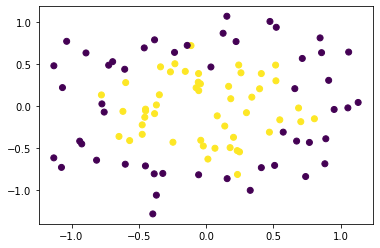

In [20]:
import pylab as plt

plt.scatter(X[::, 0], X[::, 1], c=y);

In [22]:
n_estimators=[int(x) for x in np.linspace(200, 2000, 10)]

max_features=['auto', 'sqrt']

min_samples_split=[2, 5, 10]

bootstrap=[True, False]

In [23]:
random_grid={'n_estimators': n_estimators,
             'max_features': max_features,
             'min_samples_split':min_samples_split,
             'bootstrap': bootstrap}

In [24]:
rfc=RFC()

In [25]:
rf_random=RandomizedSearchCV(estimator=rfc,
                             param_distributions=random_grid,
                             n_iter=100,
                             cv=3,
                             verbose=10,
                             n_jobs=-1, 
                             scoring='roc_auc')

In [26]:
rf_random.fit(X, y)  # ajustate para mejor modelo

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='roc_auc', verbose=10)

In [27]:
rf_random.best_estimator_.fit(X, y)  # entrenamiento del mejor modelo

RandomForestClassifier(max_features='sqrt', n_estimators=1400)

In [28]:
rf_random.best_score_

0.8870386389850058

In [29]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'max_features': 'sqrt',
 'bootstrap': True}

### HyperOpt (GridSearching bayesiano)

In [ ]:
#!pip install hyperopt

In [31]:
import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
from statsmodels.formula.api import ols

import xgboost as xgb

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts

In [32]:
df=pd.read_csv('../data/diamonds_train.csv')
df=df.dropna()

df.head()

carat        cut color clarity  depth  table  price     x     y     z
0   1.21    Premium     J     VS2   62.4   58.0   4268  6.83  6.79  4.25
1   0.32  Very Good     H     VS2   63.0   57.0    505  4.35  4.38  2.75
2   0.71       Fair     G     VS1   65.5   55.0   2686  5.62  5.53  3.65
3   0.41       Good     D     SI1   63.8   56.0    738  4.68  4.72  3.00
4   1.02      Ideal     G     SI1   60.5   59.0   4882  6.55  6.51  3.95

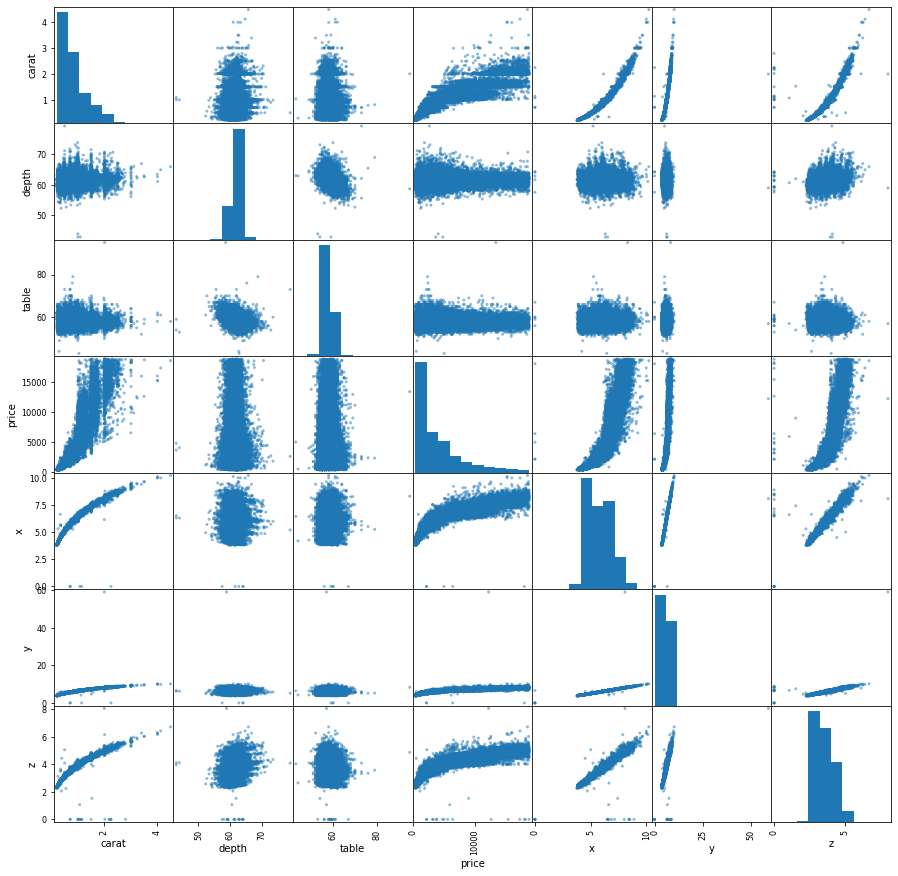

In [33]:
scatter_matrix(df, figsize=(15, 15));

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


In [35]:
X=df.drop('price', axis=1)
y=df.price

In [36]:
x=sm.add_constant(X._get_numeric_data())

In [37]:
modelo=sm.OLS(y, x).fit()

In [ ]:
pred=modelo.predict(x)

modelo.summary()

In [39]:
X=X.drop(['y', 'z'], axis=1)

In [40]:
clarity={'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4,
         'VVS2':5, 'VVS1':6, 'IF':7}


cut={'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}


color={'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}

In [41]:
def label(s, dic):
    return dic[s]

In [42]:
X.clarity=X.clarity.apply(lambda x: label(x, clarity))

X.cut=X.cut.apply(lambda x: label(x, cut))

X.color=X.color.apply(lambda x: label(x, color))

X.head()

carat  cut  color  clarity  depth  table     x
0   1.21    3      0        3   62.4   58.0  6.83
1   0.32    2      2        3   63.0   57.0  4.35
2   0.71    0      3        4   65.5   55.0  5.62
3   0.41    1      6        2   63.8   56.0  4.68
4   1.02    4      3        2   60.5   59.0  6.55

In [43]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [44]:
modelo=xgb.XGBRegressor()

modelo.fit(X_train, y_train)

y_pred=modelo.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

548.6528831793221

In [46]:
modelo

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [47]:
# aprioris

space={
    'n_estimators':hp.quniform('n_estimators', 10, 1000, 25),
    
    'learning_rate':hp.uniform('learning_rate', 0.0001, 1.0),
    
    'max_depth':hp.quniform('max_depth', 4, 16, 1),
    
    'min_child_weight':hp.quniform('min_child', 1, 10, 1),
    
    'subsample':hp.uniform('subsample', 0.7, 1),
    
    'gamma':hp.uniform('gamma', 0.1, 0.5),
    
    'reg_lambda':hp.uniform('reg_lambda', 0, 1)
}

In [48]:
def objetivo(space):
    
    modelo=xgb.XGBRegressor(
        
        n_estimators=int(space['n_estimators']),
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        subsample=space['subsample'],
        gamma=space['gamma'],
        reg_lambda=space['reg_lambda'],
        objective='reg:squarederror'
    )
    
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    modelo.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', verbose=False)
    
    y_pred=modelo.predict(X_test)
    
    rmse=mse(y_test, y_pred, squared=False)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [53]:
best=fmin(fn=objetivo,
          space=space,
          algo=tpe.suggest,
          max_evals=20,
          trials=Trials())

best

100%|███████████████████████████████████████████████████████████████████████████| 20/20 [01:50<00:00,  5.53s/trial, best loss: 534.1747371189065]


{'gamma': 0.1710751286144313,
 'learning_rate': 0.034903184875807326,
 'max_depth': 8.0,
 'min_child': 8.0,
 'n_estimators': 400.0,
 'reg_lambda': 0.6159759091859525,
 'subsample': 0.9978820565210544}

In [54]:
modelo=xgb.XGBRegressor(
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    gamma=best['gamma'],
    reg_lambda=best['reg_lambda'],
    objective='reg:squarederror'
    )

In [55]:
modelo.fit(X_train, y_train)
y_pred=modelo.predict(X_test)

mse(y_test, y_pred, squared=False)

536.3998113053572

In [56]:
m=xgb.XGBRegressor()
m.fit(X_train, y_train)
y_pred=m.predict(X_test)

mse(y_test, y_pred, squared=False)

548.6528831793221